#Assessment II - Text Classification With Recurrent Neural Network and It's Varient

##Importing Essential Tools

###Installations

In [1]:
!pip install --upgrade \
  pandas \
  numpy \
  matplotlib \
  seaborn \
  wordcloud \
  scikit-learn \
  tensorflow \
  keras \
  gensim \
  nltk \
  contractions \
  gradio \
  nlpaug

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 4.0 MB/s eta 0:00:00


>After running the pip installations, we need to restart the runtime session for the imports to work

###Imports

> Restart the session (after running the installation cell) before running the import cell

In [2]:
import os
import pickle

import pandas as pd
import numpy as np
import re
import string
import contractions
from collections import Counter

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')

import nlpaug.augmenter.word as naw

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud


from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.metrics import AUC, Precision, Recall
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import load_model

from gensim.models import Word2Vec
import gensim.downloader as api

import gradio as gr

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##Dataset Directories

In [4]:
training_dir="/content/drive/MyDrive/AI/7. Racist Sexist or Not Dataset/train_racisit.csv"
testing_dir="/content/drive/MyDrive/AI/7. Racist Sexist or Not Dataset/test_racisit.csv"

> These are the location of the triaining and tessting dataset

##Text Preprocessing, Tokenization and Sequence Padding

###Load Dataset and Basic Info

In [5]:
train_df = pd.read_csv(training_dir) #training dataset
test_df = pd.read_csv(testing_dir) #testing dataset

In [6]:
train_df.shape #displaying the shape of the training dataset which consists of number of rows and columns

(31962, 3)

In [7]:
train_df.columns

Index(['id', 'label', 'tweet'], dtype='object')

> From the shape function we can note out the following things:
- Number of Rows: 31962
- Number of Columns: 3

> The columns in the training dataframe are: id, label and tweet

In [8]:
test_df.columns

Index(['id', 'tweet'], dtype='object')

In [9]:
test_df.shape #displaying the shape of the testing dataset which consists of number of rows and columns

(17197, 2)

> From the shape function we can note out the following things:
- Number of Rows: 17197
- Number of Columns: 2

In [10]:
train_df.isnull().sum()

,0
id,0
label,0
tweet,0


> Here we're checking if there are any null values in the any of the columns, there are no null values.

In [11]:
print("First 5 Training Data:")
train_df.head() #displaying the first five rows of the dataframe of training dataset

First 5 Training Data:


,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [12]:
print("First 5 Testing Data:")
test_df.head() #displaying the first five rows of the dataframe of testing dataset

First 5 Testing Data:


,id,tweet
0,31963,#studiolife #aislife #requires #passion #dedic...
1,31964,@user #white #supremacists want everyone to s...
2,31965,safe ways to heal your #acne!! #altwaystohe...
3,31966,is the hp and the cursed child book up for res...
4,31967,"3rd #bihday to my amazing, hilarious #nephew..."


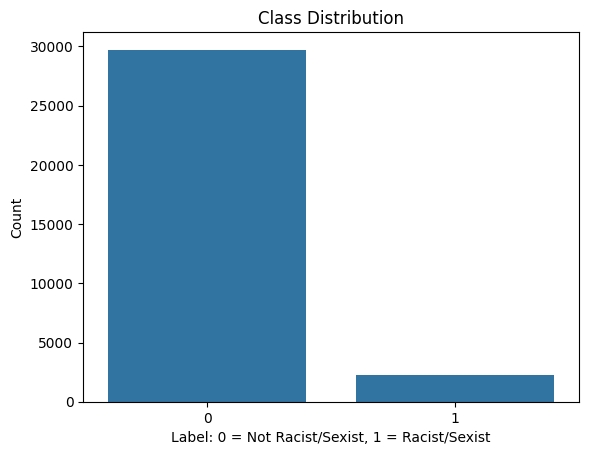

In [13]:
sns.countplot(x='label', data=train_df)
plt.title("Class Distribution")
plt.xlabel("Label: 0 = Not Racist/Sexist, 1 = Racist/Sexist")
plt.ylabel("Count")
plt.show()

> In the given count plot we can see the number of tweets labeled as 0(Not Racist/Sexist) and the number of tweets labeled as 1 (Racist/Sexist) in the training dataset.

> In the count plot we can clearly notice the uneven distribution of data in the dataset where the maximum number of tweets are labeled as "Not Racist/Sexist" which can give false sense of accuracy while training.

###Text Cleaning Helper Functions

####Texts Lowercased

In [14]:
def lowercase_it(your_text):
  return your_text.lower()

> The helper funtion is created to change the given text into lowercase.

####URLs, mentions, hashtags, numbers and special characters Removal

In [15]:
def exclude_url_mentions_hashtags_numbers_sCharacters(your_text):
  your_text = re.sub(r"http\S+|www\S+|https\S+", '', your_text, flags=re.MULTILINE) #here we're removing URLs flags=re.MULTILINE used so that if the strings are multilines the entire string is scanned instead of the only first line
  your_text = re.sub(r'\@\w+|\#', '', your_text) #here we're removing @mentions
  your_text = re.sub(r'\d+', '', your_text) #here we're removing numbers
  your_text = re.sub(r'&\w+;', '', your_text) #here we're removing the HTML entities
  your_text = re.sub(r'[^\x00-\x7F]+', ' ', your_text) #here we're removing non-ascii characters
  your_text = re.sub(r'[^\w\s]', '', your_text) #here we're removing punctuations
  return your_text

> The helper function is created to remove any urls or mentions(@), hashtags or numbers or special characters from given texts

####Contractions Handled

In [16]:
def handle_your_contractions_dude(your_text):
  return contractions.fix(your_text)

> This function is used to handle contractions like: don't => do not.

####Stopwords Removal and Lemmatization

In [17]:
def get_rid_of_stopwords(your_text):
  your_tokens = nltk.word_tokenize(your_text)
  your_filtered_tokens = [word for word in your_tokens if word not in stopwords.words('english')]
  return ' '.join(your_filtered_tokens)

In [18]:
def get_it_lemmatized(your_text):
  lemmatizer = WordNetLemmatizer()
  tokens = nltk.word_tokenize(your_text)
  lemmatized_tokens = [lemmatizer.lemmatize(word) for word in tokens]
  return ' '.join(lemmatized_tokens)

> These functions are used for stopword removal or the words which do not significantly impact the meaning of a sentence and lemmatizing the words (taking a word into it's root form)

####Combined Function

In [19]:
def get_em_cleaned(your_text):
  your_text = lowercase_it(your_text)
  your_text = handle_your_contractions_dude(your_text)
  your_text = exclude_url_mentions_hashtags_numbers_sCharacters(your_text)
  your_text = get_rid_of_stopwords(your_text)
  your_text = get_it_lemmatized(your_text)
  return your_text

> In this function all the cleaner functions are combined in the one place

###Balancing and Cleaning Texts

In [20]:
train_df = train_df.drop("id", axis = 1)
test_df = test_df.drop("id", axis = 1)

> We're dropping the id column because it doesn't contain any useful information and is used for only unique identification.

In [21]:
train_df['cleaned_tweet'] = train_df['tweet'].apply(get_em_cleaned)
test_df['cleaned_tweet'] = test_df['tweet'].apply(get_em_cleaned)

In [22]:
train_df['label'].value_counts() #here we're showing the counts of the two labels after cleaning the tweets

,count
label,
0,29720
1,2242


> Here we can see the count of both classes after cleaning and before augmentation fo the data

In [23]:
aug = naw.SynonymAug(aug_src='wordnet', aug_p=0.3) #here we're specifying the source for the synonyms of the word and the probablity of a word getting replaces with it synonnym
minority_tweets = train_df[train_df['label'] == 1]['cleaned_tweet'].tolist()

augmented_texts = []
for tweet in minority_tweets:
    augmented_texts.extend(aug.augment(tweet) for _ in range(2))

augmented_df = pd.DataFrame({
    'cleaned_tweet': augmented_texts,
    'label': [1] * len(augmented_texts)
})

train_df = pd.concat([train_df, augmented_df], ignore_index=True).sample(frac=1, random_state=42)

> In our dataset, we can clearly see a huge imbalance in the distribution of the dataset. Thus to tackle the problem of one class overwhelming the model, we are applying data augmentation for the inferior class or the class with less amout of data i.e. 1 (Racist/Sexist).

> We're using the naw (Natural Language Augmentation) library for data augmentation

> In the augmentation technique, the word in a sentence are replaced with their synonyms from WordNet which helps in creating augmented sentences which can help is better distrubution of data.

In [24]:
train_df['label'].value_counts()

,count
label,
0,29720
1,6726


In [25]:
train_df.count()


,0
label,36446
tweet,31962
cleaned_tweet,36446


> Here we can see the count of both classes after cleaning and after augmentation fo the data.

> The number of "1 or racist/sexist" class has increased by more than 4 thousand.

###Visualizing Cleaned Data

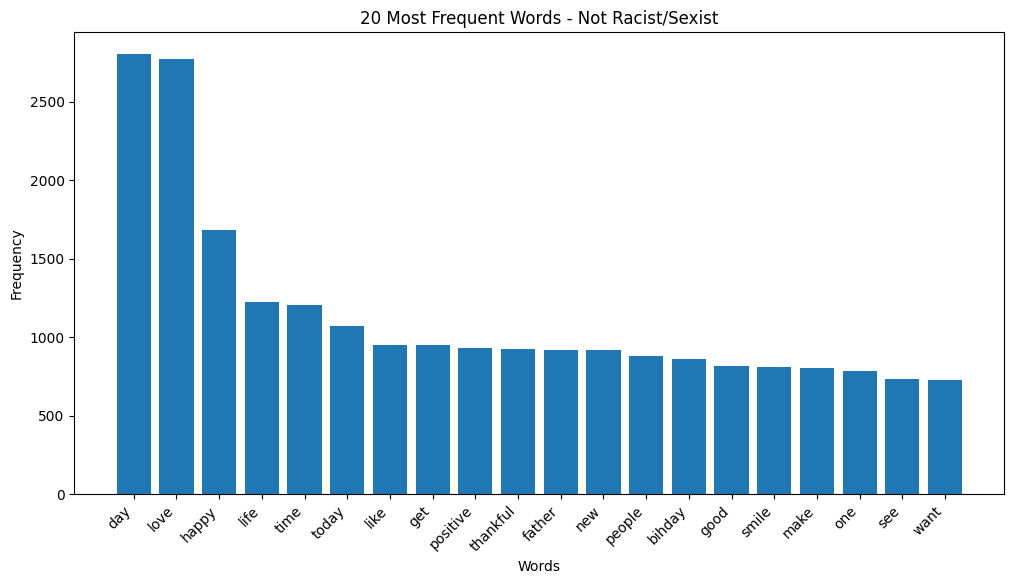

In [26]:
non_racist_sexist_tweets = train_df[train_df['label'] == 0]['cleaned_tweet']

all_tokens = []
for tweet in non_racist_sexist_tweets:
    if isinstance(tweet, str):
        tokens = tweet.split()
    elif isinstance(tweet, (list, tuple)):
        tokens = tweet
    else:
        continue
    all_tokens.extend(tokens)

word_freq = Counter(all_tokens)
most_common_words = word_freq.most_common(20)
words, counts = zip(*most_common_words)

plt.figure(figsize=(12, 6))
plt.bar(words, counts)
plt.xticks(rotation=45, ha='right')
plt.title('20 Most Frequent Words - Not Racist/Sexist')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.show()

> Here we can see the 20 most highly used words which are labeled as "0 or Not Racist/Sexist"

>Most used words in non-racist/sexist texts:
- day
- love
- happy
- life
- time


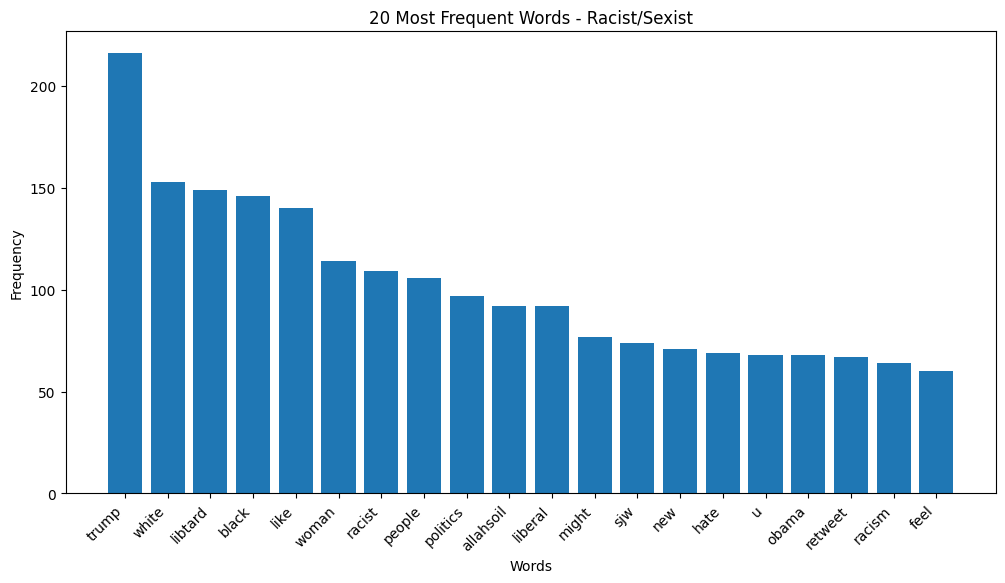

In [27]:
racist_sexist_tweets = train_df[train_df['label'] == 1]['cleaned_tweet']

all_tokens = []
for tweet in racist_sexist_tweets:
    if isinstance(tweet, str):
        tokens = tweet.split()
    elif isinstance(tweet, (list, tuple)):
        tokens = tweet
    else:
        continue
    all_tokens.extend(tokens)

word_freq = Counter(all_tokens)
most_common_words = word_freq.most_common(20)
words, counts = zip(*most_common_words)

plt.figure(figsize=(12, 6))
plt.bar(words, counts)
plt.xticks(rotation=45, ha='right')
plt.title('20 Most Frequent Words - Racist/Sexist')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.show()

> Here we can see the 20 most highly used words which are labeled as "1 or Racist/Sexist"

> Most used words in racist/sexist texts:
- trump
- white
- libtard
- like
- people

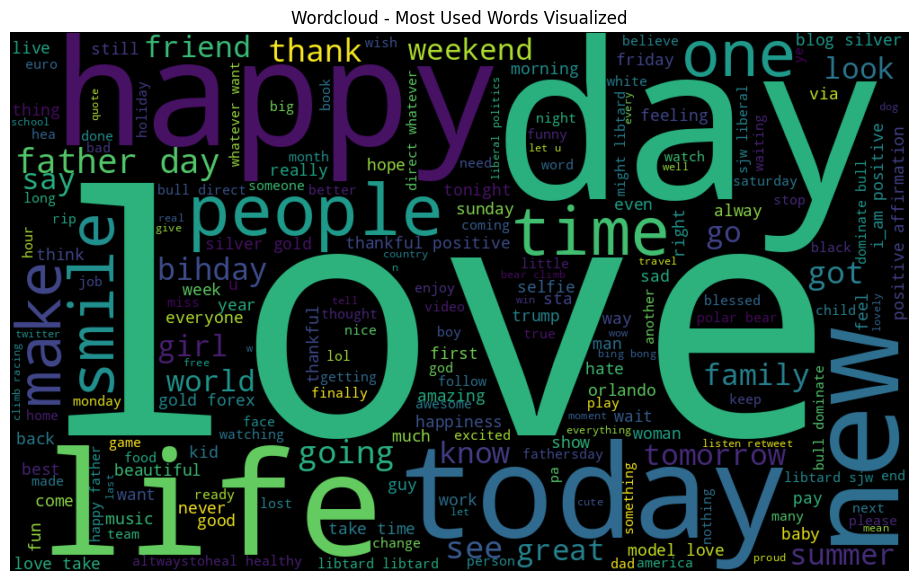

In [28]:
texts_train_df = []
for tweet in train_df['cleaned_tweet']:
    if isinstance(tweet, str):
        texts_train_df.append(tweet)
    elif isinstance(tweet, (list, tuple)):
        texts_train_df.append(' '.join(tweet))

all_cleaned_text = ' '.join(texts_train_df)

wordcloud = WordCloud(width=1000, height=600, background_color='black') \
    .generate(all_cleaned_text)

plt.figure(figsize=(12, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title("Wordcloud - Most Used Words Visualized")
plt.axis('off')
plt.show()

> Here we can see the most highly used words in the training dataset using WordCloud

> Some of the most frequent words being: love, day, happy, people, today

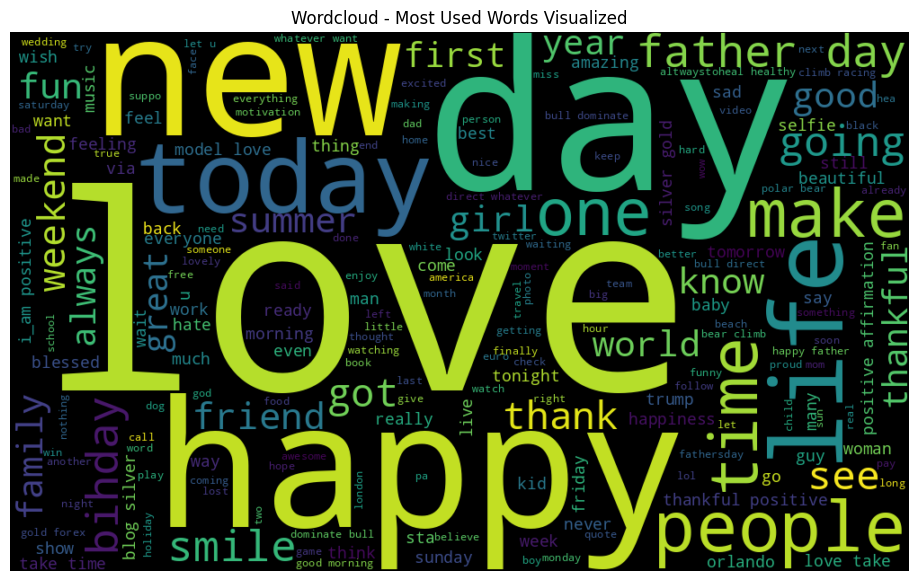

In [29]:
texts_test_df = []
for tweet in test_df['cleaned_tweet']:
    if isinstance(tweet, str):
        texts_test_df.append(tweet)
    elif isinstance(tweet, (list, tuple)):
        texts_test_df.append(' '.join(tweet))

all_cleaned_text = ' '.join(texts_test_df)

wordcloud = WordCloud(width=1000, height=600, background_color='black') \
    .generate(all_cleaned_text)

plt.figure(figsize=(12, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title("Wordcloud - Most Used Words Visualized")
plt.axis('off')
plt.show()

> Here we can see the most highly used words in the training dataset using WordCloud

>We can see that in training and testing both, similar words are appearing most frequently where some of the most frequent words being: love, day, happy, people, today

###Tokenization and Padding

In [30]:
features_X = train_df['cleaned_tweet']
target_y = train_df['label']

features_X_train, features_X_val, target_y_train, target_y_val = train_test_split(features_X, target_y, test_size=0.2, random_state=42, shuffle=True, stratify=target_y)

> Using the train_test_split function of sklearn, here we're splitting the training dataframe into training and validation data where 80% data will be allocated to the training and 20% will allocated for validation

In [31]:
tokenizer = Tokenizer() #creating tokenizer object for building vocabulary for the training data
tokenizer.fit_on_texts(features_X_train) #the fit_on_texts function builds word index dictionary from the features of training

#converting the texts into list of integers or word indices
feature_X_train_sequence = tokenizer.texts_to_sequences(features_X_train)
feature_X_val_sequence = tokenizer.texts_to_sequences(features_X_val)
feature_X_test_seq = tokenizer.texts_to_sequences(test_df['cleaned_tweet'])


> Here tokenizer is being created to fit it on the training data to build the vocabulary and to convert all text data into word indices to be later fitted to the network

In [32]:
sequence_lengths = [len(seq) for seq in feature_X_train_sequence]

maxlen = int(np.percentile(sequence_lengths, 95))
print(f"Padding all sequences to length: {maxlen}")

feature_X_train_pad = pad_sequences(feature_X_train_sequence, maxlen=maxlen, padding='post', truncating='post')
feature_X_val_pad = pad_sequences(feature_X_val_sequence, maxlen=maxlen, padding='post', truncating='post')

feature_X_test_pad = pad_sequences(feature_X_test_seq, maxlen=maxlen)

Padding all sequences to length: 12


> Here the 95th percentile of the training sequnce is calulated to set a reasonable maximum length and to pad the sequences to that length for them to get processessed uniformly by the model

##Model Building

###Simple Recurrent Neural Network with Embedding Layer

In [33]:
vocab_size = len(tokenizer.word_index) + 1 # +1 is used because index 0 is reserved for padding
embedding_dim = 100 #here dimension of the embedding is set
input_length = feature_X_train_pad.shape[1] #the length of the input is initialized

> Here, we are initializing the vocab size, setting the dimension of word embeddings and getting the lenght of each input sequence after padding.

In [34]:
simple_rnn_model_with_emb = Sequential() #we're creating a sequential modal where there are layers stacked one after another
simple_rnn_model_with_emb.add(Embedding( #this is the embedding layer which converts integer tokens in to vectors of a assigned size
    input_dim=vocab_size,
    output_dim=embedding_dim,
    input_length=input_length
))
simple_rnn_model_with_emb.add(Dropout(0.3)) #we're also adding a drop our layer here to avoid the model from overfitting (this randomly turns off 0.3 or 30% of the inputs to the next layer in training)
simple_rnn_model_with_emb.add(SimpleRNN( #this is the simplern model where we've set certain parameters
    units=64,
    return_sequences=False,
    dropout=0.2,
    recurrent_dropout=0.2
))
simple_rnn_model_with_emb.add(BatchNormalization()) #adding batch normalizationw which helps in normalizing the activations for stable training and speed improvements
simple_rnn_model_with_emb.add(Dropout(0.3)) #another additional dropout layer again to avoid overfitting
simple_rnn_model_with_emb.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.001))) #here we're adding a dense output layer where we've used sigmoid as our activation function since we've got 2 classes in the dataset i.e. 0 or 1

simple_rnn_model_with_emb.build(input_shape=(None, input_length)) #here the model is initialized witht the expected input length (for showing the summary)

simple_rnn_model_with_emb.summary() #for displaying the summary of the model


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 12, 100)        │     3,527,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 12, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ (None, 64)             │        10,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,538,381 (13.50 MB)

 Trainable params: 3,538,253 (13.50 MB)

 Non-trainable params: 128 (512.00 B)

> Here, we can see the structure of the Simple RNN model and see the total number of parameters in the model.

> There are 6 Layers in the Model that are:
- Embedding Layer - 1
- Dropout Layer - 2
- Simple RNN Layer - 1
- Batch Normalizaiton Layer - 1
- Dense Layer - 1

> There are total 3,855,781 parameters in the model which are mostly in the embedding layer of the model which takes the input sequences.

> The dropout layer is responsible for randomly droping the inputs to the next layer randomly with 30% possibility which helps in preventing overfitting.

> The Simple RNN layer processes the input sequences using 64 RNN units or neurons.

> The BatchNormalization layer is responsible for normalizing the output of the RNN which helps in normalizing the activations.

> The dense or fully connected layer is used for getting the output prediction from the model using sigmoid activation function.

###Long Short-Term Memory with Embedding Layer

In [35]:
lstm_model_with_emb = Sequential()
lstm_model_with_emb.add(Embedding(
    input_dim=vocab_size,
    output_dim=embedding_dim,
    input_length=input_length
))
lstm_model_with_emb.add(Dropout(0.3))
lstm_model_with_emb.add(LSTM( #this lstm model process the data and outputs the final hidden state, adds memory and context to the model
    units=64,
    return_sequences=False,
    dropout=0.3,
    recurrent_dropout=0.3,
    kernel_regularizer=l2(0.001)
))
lstm_model_with_emb.add(BatchNormalization())
lstm_model_with_emb.add(Dropout(0.4))
lstm_model_with_emb.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.001)))

lstm_model_with_emb.build(input_shape=(None, input_length))
lstm_model_with_emb.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 12, 100)        │     3,527,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 12, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        42,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,570,061 (13.62 MB)

 Trainable params: 3,569,933 (13.62 MB)

 Non-trainable params: 128 (512.00 B)

> Here, we can see the structure of the LSTM with word embedding model and see the total number of parameters in the model.

> There are 6 Layers in the Model that are:
- Embedding Layer - 1
- Dropout Layer - 2
- LSTM Layer - 1
- Batch Normalizaiton Layer - 1
- Dense Layer - 1

> There are total 3,857,461 parameters in the model which are mostly in the embedding layer of the model which takes the input sequences.

> The dropout layer is responsible for randomly droping the inputs to the next layer randomly with 30% possibility which helps in preventing overfitting.

> The LSTM layer processes the input sequences using 64 RNN units or neurons.

> The BatchNormalization layer is responsible for normalizing the output of the RNN which helps in normalizing the activations.

> The dense or fully connected layer is used for getting the output prediction from the model using sigmoid activation function.

###LSTM with pretrained Word2Vec embeddings.

In [36]:
embedding_model = api.load('glove-twitter-200') #here we're loading the glove twitter of 200 dimension embeddings
embedding_dim = 200 #this is the dimension size

[==================================================] 100.0% 758.5/758.5MB downloaded


> Here we're using the pretrained word vector from glove twitter - 200 dimensions gensim.dowloader

In [37]:
vocab_size = len(tokenizer.word_index) + 1
word_index = tokenizer.word_index

embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in word_index.items():
    if word in embedding_model:
        embedding_matrix[i] = embedding_model[word]

Here, the embedding matrix isbeing created where each row is a word in our text or vocabulary and it contains 200-dimesionals glove vector, it fill missing areas with zeros

In [38]:
input_length = feature_X_train_pad.shape[1]

lstm_word2vec_model = Sequential()
lstm_word2vec_model.add(Embedding(
    input_dim=vocab_size,
    output_dim=embedding_dim,
    weights=[embedding_matrix],
    input_length=input_length,
    trainable=True
))
lstm_word2vec_model.add(Dropout(0.3))
lstm_word2vec_model.add(LSTM(64, dropout=0.3, recurrent_dropout=0.3))
lstm_word2vec_model.add(BatchNormalization())
lstm_word2vec_model.add(Dropout(0.4))
lstm_word2vec_model.add(Dense(1, activation='sigmoid'))

lstm_word2vec_model.build(input_shape=(None, input_length))
lstm_word2vec_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 12, 200)        │     7,055,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 12, 200)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        67,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,123,161 (27.17 MB)

 Trainable params: 7,123,033 (27.17 MB)

 Non-trainable params: 128 (512.00 B)

> Here, we can see the structure of the LSTM with word embedding model and see the total number of parameters in the model.

> There are 6 Layers in the Model that are:
- Embedding Layer - 1
- Dropout Layer - 2
- LSTM Layer - 1
- Batch Normalizaiton Layer - 1
- Dense Layer - 1

> There are total 7,757,961 parameters in the model which are mostly in the embedding layer of the model which takes the input sequences.

> The dropout layer is responsible for randomly droping the inputs to the next layer randomly with 30% possibility which helps in preventing overfitting.

> The LSTM layer processes the input sequences using 64 RNN units or neurons.

> The BatchNormalization layer is responsible for normalizing the output of the RNN which helps in normalizing the activations.

> The dense or fully connected layer is used for getting the output prediction from the model using sigmoid activation function.

##Model Training and Evaluation

###Simple Recurrent Neural Network with Embedding Training

In [39]:
simple_rnn_model_with_emb.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy', AUC(name='auc'), Precision(name='precision'), Recall(name='recall')]
)

> Here we're compiling the model which involves setting the model's loss function, optimizer (weight updation technique), performance tracking metrics.

>Since we noticed that the model's class distribution is imbalanced, we're using auc, precision and recall for checking the actual performace of model more than relying on just accuracy.

In [40]:
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(target_y_train),
    y=target_y_train
)
class_weight_dict = dict(enumerate(class_weights))


callbacks_simple_rnn = [
    EarlyStopping(monitor='val_auc', mode='max', patience=8, restore_best_weights=True),
    ModelCheckpoint('simple_rnn_pred_model.keras', monitor='val_auc', mode='max', save_best_only=True),
    ReduceLROnPlateau(monitor='val_auc', mode='max', patience=2, factor=0.5, min_lr=1e-6),
]

history_simple_rnn_with_emb = simple_rnn_model_with_emb.fit(
    feature_X_train_pad, target_y_train,
    validation_data=(feature_X_val_pad, target_y_val),
    epochs=20,
    batch_size=16,
    callbacks=callbacks_simple_rnn,
    class_weight=class_weight_dict
)

Epoch 1/20
1823/1823 ━━━━━━━━━━━━━━━━━━━━ 75s 38ms/step - accuracy: 0.7722 - auc: 0.8256 - loss: 0.5212 - precision: 0.4540 - recall: 0.7645 - val_accuracy: 0.9222 - val_auc: 0.9000 - val_loss: 0.2758 - val_precision: 0.7763 - val_recall: 0.8126 - learning_rate: 0.0010
Epoch 2/20
1823/1823 ━━━━━━━━━━━━━━━━━━━━ 84s 40ms/step - accuracy: 0.9192 - auc: 0.9382 - loss: 0.2911 - precision: 0.7400 - recall: 0.8813 - val_accuracy: 0.9281 - val_auc: 0.9533 - val_loss: 0.2282 - val_precision: 0.7783 - val_recall: 0.8535 - learning_rate: 0.0010
Epoch 3/20
1823/1823 ━━━━━━━━━━━━━━━━━━━━ 77s 37ms/step - accuracy: 0.9388 - auc: 0.9669 - loss: 0.2106 - precision: 0.7846 - recall: 0.9230 - val_accuracy: 0.9358 - val_auc: 0.9562 - val_loss: 0.2327 - val_precision: 0.7941 - val_recall: 0.8803 - learning_rate: 0.0010
Epoch 4/20
1823/1823 ━━━━━━━━━━━━━━━━━━━━ 83s 38ms/step - accuracy: 0.9495 - auc: 0.9799 - loss: 0.1657 - precision: 0.8169 - recall: 0.9391 - val_accuracy: 0.9224 - val_auc: 0.9572 - val_lo

> For the Simple RNN model we first set the epochs to 10 to train the model as high accuracy was obtained even in the begginning of the training but since, there was no sign of overfitting till the 10th epoc we increaed the epochs to 20. Also we can see the validation precision and recall ahve also started out pretty high i.e. 0.78 precision and 0.80 recall.

>We decreased the batch size from 32 to 16 because the model's class distribution is imbalanced and also, the model was unable to learn proper predictions for the "1 or Racist" class due to less data.

>Another thing we did for tackling the class distribution imbalance was to use the compute_class_weight function which helps in giving the minority class more importance will training to avoid bias results.

>The callbacks we've used for training the models are:
- EarlyStopping
- ModelCheckpoint
- ReduceLROnPlateau


###LSTM with Embedding Layer Training

In [41]:
lstm_model_with_emb.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy', AUC(name='auc'), Precision(name='precision'), Recall(name='recall')]
)

In [42]:
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(target_y_train),
    y=target_y_train
)
class_weight_dict = dict(enumerate(class_weights))

callbacks_lstm_with_emb = [
    EarlyStopping(monitor='val_auc', patience=5, restore_best_weights=True, mode='max'),
    ModelCheckpoint('lstm_pred_model.keras', save_best_only=True, mode="max", monitor="val_auc"),
    ReduceLROnPlateau(monitor='val_loss', patience=2)
]

history_lstm_with_emb = lstm_model_with_emb.fit(
    feature_X_train_pad, target_y_train,
    validation_data=(feature_X_val_pad, target_y_val),
    epochs=10,
    batch_size=16,
    callbacks=callbacks_lstm_with_emb,
    class_weight=class_weight_dict
)

Epoch 1/10
1823/1823 ━━━━━━━━━━━━━━━━━━━━ 119s 63ms/step - accuracy: 0.7880 - auc: 0.8785 - loss: 0.4900 - precision: 0.4784 - recall: 0.8251 - val_accuracy: 0.9247 - val_auc: 0.9706 - val_loss: 0.2577 - val_precision: 0.7481 - val_recall: 0.8922 - learning_rate: 0.0010
Epoch 2/10
1823/1823 ━━━━━━━━━━━━━━━━━━━━ 144s 64ms/step - accuracy: 0.9456 - auc: 0.9808 - loss: 0.1908 - precision: 0.8029 - recall: 0.9394 - val_accuracy: 0.9343 - val_auc: 0.9744 - val_loss: 0.2555 - val_precision: 0.7747 - val_recall: 0.9078 - learning_rate: 0.0010
Epoch 3/10
1823/1823 ━━━━━━━━━━━━━━━━━━━━ 140s 63ms/step - accuracy: 0.9657 - auc: 0.9884 - loss: 0.1375 - precision: 0.8660 - recall: 0.9575 - val_accuracy: 0.9417 - val_auc: 0.9722 - val_loss: 0.2397 - val_precision: 0.8142 - val_recall: 0.8862 - learning_rate: 0.0010
Epoch 4/10
1823/1823 ━━━━━━━━━━━━━━━━━━━━ 119s 65ms/step - accuracy: 0.9756 - auc: 0.9918 - loss: 0.1067 - precision: 0.8970 - recall: 0.9765 - val_accuracy: 0.9514 - val_auc: 0.9718 - va

> For the LSTM with Embedding layer too we've set 10 epochs to train the model as high accuracy was obtained even in the begginning of the training. Also we can see the validation precision and recall ahve also started out pretty high i.e. 0.78 precision and 0.80 recall.

>We decreased the batch size from 32 to 16 because the model's class distribution is imbalanced and also, the model was unable to learn proper predictions for the "1 or Racist" class due to less data.

>Another thing we did for tackling the class distribution imbalance was to use the compute_class_weight function which helps in giving the minority class more importance will training to avoid bias results.

>The callbacks we've used for training the models are:
- EarlyStopping
- ModelCheckpoint
- ReduceLROnPlateau


###LSTM with pretrained Word2Vec embeddings

In [43]:
lstm_word2vec_model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy', AUC(name='auc'), Precision(name='precision'), Recall(name='recall')]
)

In [44]:
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(target_y_train),
    y=target_y_train
)
class_weight_dict = dict(enumerate(class_weights))

callbacks_word2vec = [
    EarlyStopping(monitor='val_auc', patience=5, restore_best_weights=True, mode='max'),
    ModelCheckpoint('lstm_word2vec_pred_model.keras', save_best_only=True, mode="max", monitor="val_auc"),
    ReduceLROnPlateau(monitor='val_loss', patience=2)
]

history_word2vec = lstm_word2vec_model.fit(
    feature_X_train_pad, target_y_train,
    validation_data=(feature_X_val_pad, target_y_val),
    epochs=20,
    batch_size=32,
    callbacks=callbacks_word2vec,
    class_weight=class_weight_dict
)

Epoch 1/20
912/912 ━━━━━━━━━━━━━━━━━━━━ 105s 109ms/step - accuracy: 0.7751 - auc: 0.8854 - loss: 0.4383 - precision: 0.4662 - recall: 0.8687 - val_accuracy: 0.9376 - val_auc: 0.9764 - val_loss: 0.1834 - val_precision: 0.7995 - val_recall: 0.8833 - learning_rate: 0.0010
Epoch 2/20
912/912 ━━━━━━━━━━━━━━━━━━━━ 139s 107ms/step - accuracy: 0.9358 - auc: 0.9757 - loss: 0.1964 - precision: 0.7753 - recall: 0.9185 - val_accuracy: 0.9543 - val_auc: 0.9809 - val_loss: 0.1468 - val_precision: 0.8651 - val_recall: 0.8914 - learning_rate: 0.0010
Epoch 3/20
912/912 ━━━━━━━━━━━━━━━━━━━━ 143s 107ms/step - accuracy: 0.9562 - auc: 0.9867 - loss: 0.1399 - precision: 0.8366 - recall: 0.9434 - val_accuracy: 0.9558 - val_auc: 0.9829 - val_loss: 0.1462 - val_precision: 0.8651 - val_recall: 0.9011 - learning_rate: 0.0010
Epoch 4/20
912/912 ━━━━━━━━━━━━━━━━━━━━ 142s 107ms/step - accuracy: 0.9658 - auc: 0.9915 - loss: 0.1090 - precision: 0.8683 - recall: 0.9622 - val_accuracy: 0.9580 - val_auc: 0.9829 - val_lo

>Here we can see the training of the LSTM model with pretrained Word2Vec embeddings. We can notice that the validation auc of the model increases till only the 4th epoch and is in the decreasing trend but, we can see the validation precision and recall improved but as validation precision was improving we can see the recall decreasing.

>Another thing we did for tackling the class distribution imbalance was to use the compute_class_weight function which helps in giving the minority class more importance will training to avoid bias results.

>The callbacks we've used for training the models are:
- EarlyStopping
- ModelCheckpoint
- ReduceLROnPlateau


In [45]:
with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

> Saving the Tokenizer after the model taining

###Visualization and Evaluation

####Accuracy and Loss Plots

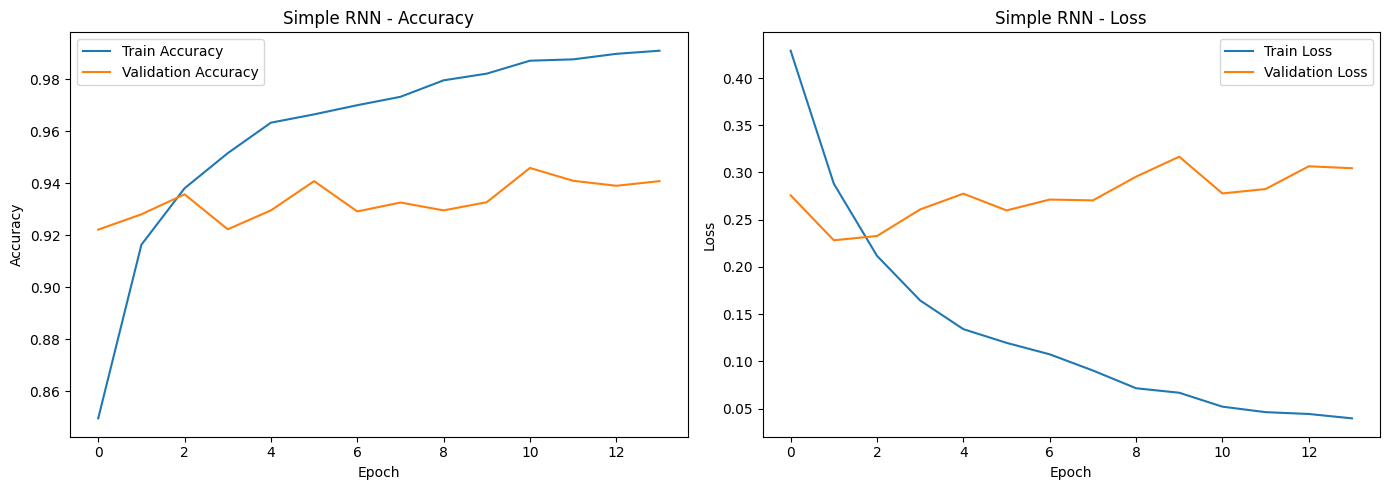

In [46]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history_simple_rnn_with_emb.history['accuracy'], label='Train Accuracy')
plt.plot(history_simple_rnn_with_emb.history['val_accuracy'], label='Validation Accuracy')
plt.title('Simple RNN - Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_simple_rnn_with_emb.history['loss'], label='Train Loss')
plt.plot(history_simple_rnn_with_emb.history['val_loss'], label='Validation Loss')
plt.title('Simple RNN - Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

> Here in the accuracy plot, we can see that the accuracy is in the rising trend but the validation accuracy starts good and in a constant range neither significantly increasing or decreasing.

> In the loss plot plot we can see that the model's loss has slightly decreased till epoch 3 but after that it has started to rise indicating overfitting of the model.

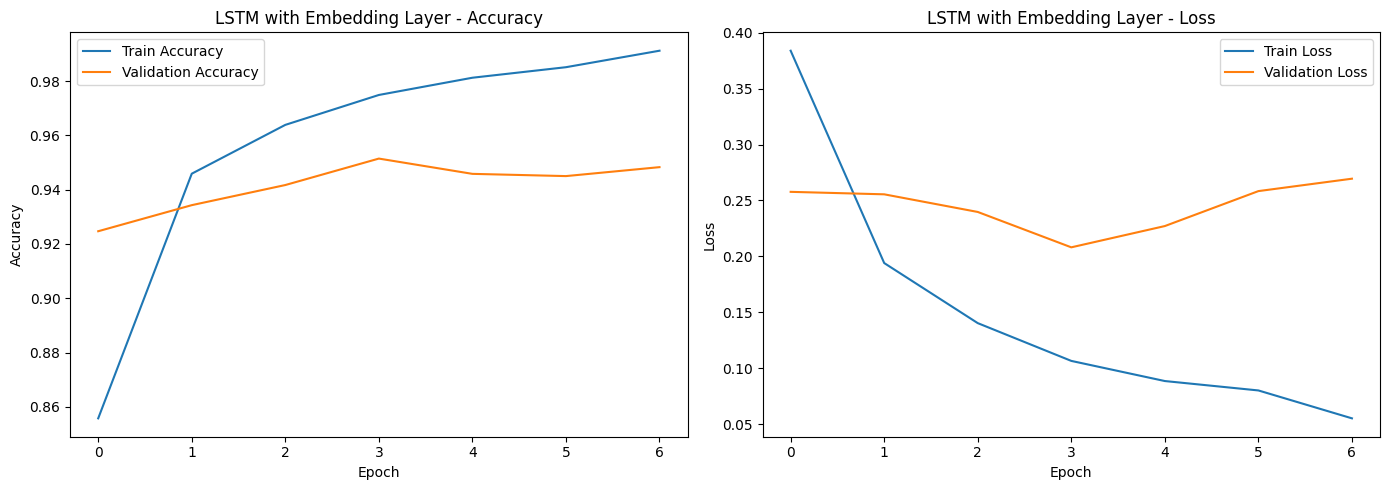

In [47]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history_lstm_with_emb.history['accuracy'], label='Train Accuracy')
plt.plot(history_lstm_with_emb.history['val_accuracy'], label='Validation Accuracy')
plt.title('LSTM with Embedding Layer - Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_lstm_with_emb.history['loss'], label='Train Loss')
plt.plot(history_lstm_with_emb.history['val_loss'], label='Validation Loss')
plt.title('LSTM with Embedding Layer - Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

> In the accuracy plot we can see that the training accuracy is in the rising trend where as the validation accuracy is quite constant with a dip in epoch 3 but again it rose to the initial accuracy point.

> In the loss plot we can see that the loss starts pretty low and in the 3rd epoch we can se the spike in the validation loss but after the 3rd epoch we can see the loss get back down and gradually decrease

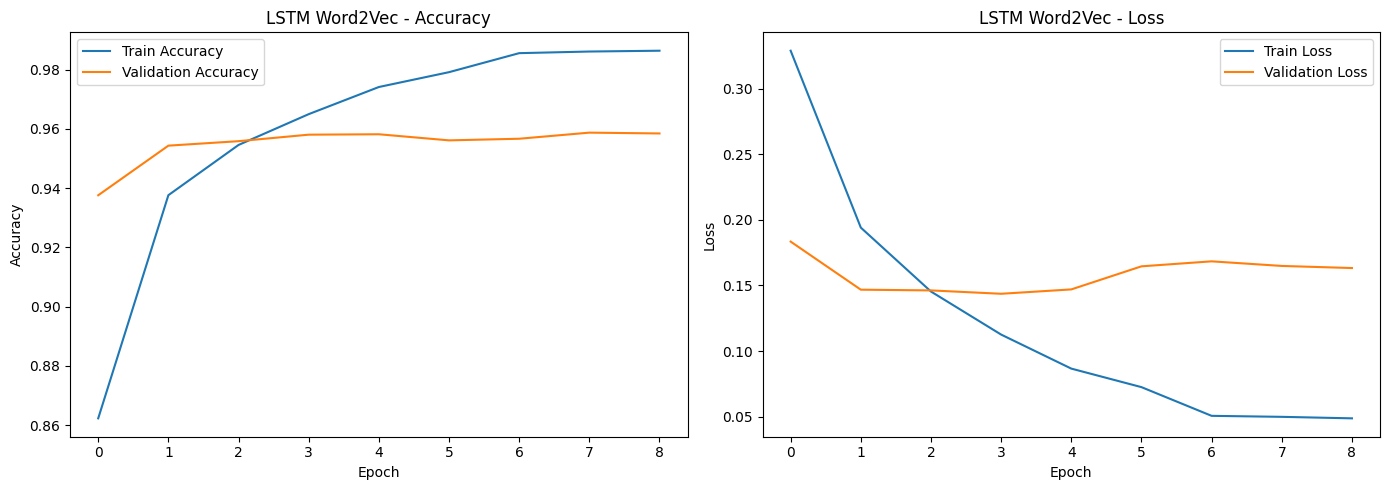

In [48]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history_word2vec.history['accuracy'], label='Train Accuracy')
plt.plot(history_word2vec.history['val_accuracy'], label='Validation Accuracy')
plt.title('LSTM Word2Vec - Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_word2vec.history['loss'], label='Train Loss')
plt.plot(history_word2vec.history['val_loss'], label='Validation Loss')
plt.title('LSTM Word2Vec - Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

> In the accuracy plot, we can see that the training accuracy is in the rising trend and we can also see that in validation accuracy, in epoch 2 the validaiton accuracy has a slight fall and then it rises and in the rising trend.

> In the loss plot, we can see that the training loss in a decreasing trend but the validation loss doesn't have a significant fall and even rises on 2 to 3 epochs.

####AUC Plots

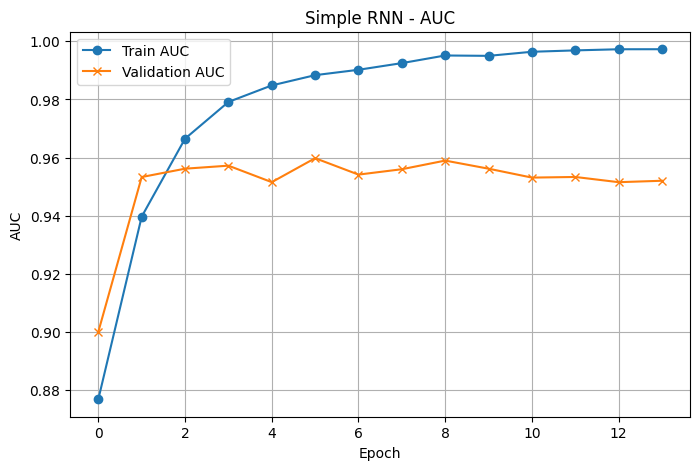

In [49]:
simple_rnn_train_auc = history_simple_rnn_with_emb.history['auc']
simple_rnn_test_auc = history_simple_rnn_with_emb.history['val_auc']

plt.figure(figsize=(8, 5))
plt.plot(simple_rnn_train_auc, label='Train AUC', marker='o')
plt.plot(simple_rnn_test_auc, label='Validation AUC', marker='x')
plt.title('Simple RNN - AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()
plt.grid(True)
plt.show()

> Here in the Simple RNN AUC plot we can see that the validation and training AUC increase. Even though the training AUC constantly increases, the validaiton AUC sees a hike till epoch 2 and then starts to dip, getting lowest in the 6th epoch.

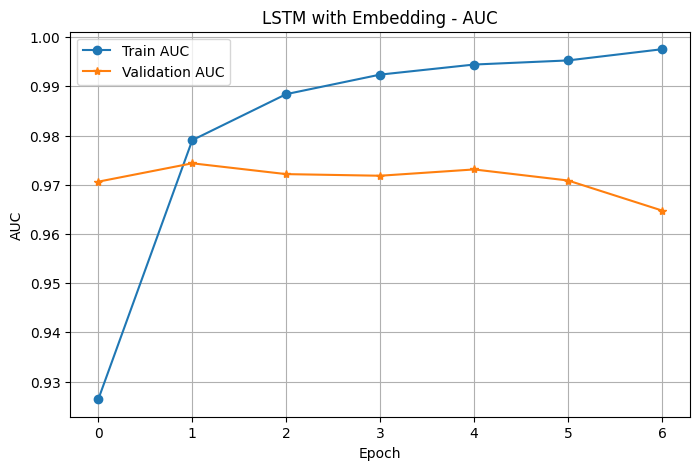

In [50]:
lstm_model_with_emb_train_auc = history_lstm_with_emb.history['auc']
lstm_model_with_emb_test_auc = history_lstm_with_emb.history['val_auc']

plt.figure(figsize=(8, 5))
plt.plot(lstm_model_with_emb_train_auc, label='Train AUC', marker='o')
plt.plot(lstm_model_with_emb_test_auc, label='Validation AUC', marker='*')
plt.title('LSTM with Embedding - AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()
plt.grid(True)
plt.show()

> In the AUC plot of the LSTM model with trainable embeddings we can see that the validation AUC starts of high and slightly decreases and remains constant from the 4th epoch.

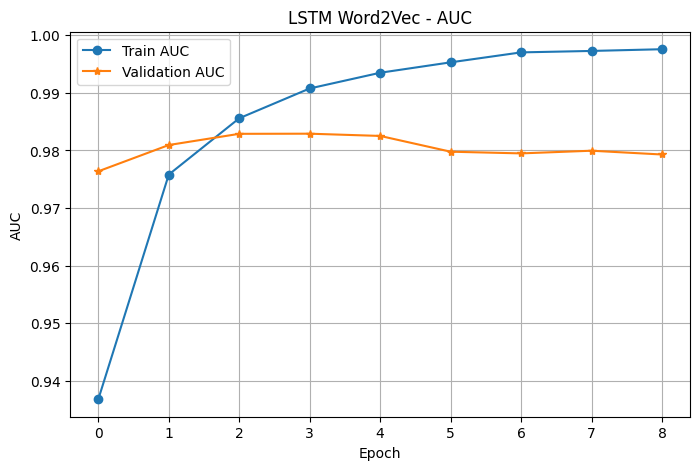

In [51]:
lstm_word2vec_model_train_auc = history_word2vec.history['auc']
lstm_word2vec_model_test_auc = history_word2vec.history['val_auc']

plt.figure(figsize=(8, 5))
plt.plot(lstm_word2vec_model_train_auc, label='Train AUC', marker='o')
plt.plot(lstm_word2vec_model_test_auc, label='Validation AUC', marker='*')
plt.title('LSTM Word2Vec - AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()
plt.grid(True)
plt.show()

> In the LSTM with Word2Vec embeddings we can see that the training auc rises rapidly and is in an increasing trend but the validation accuracy see a slight increased till apoch 2 but starts to fall and remains constant from epoch 6 to 8.

####Precision and Recall Plots

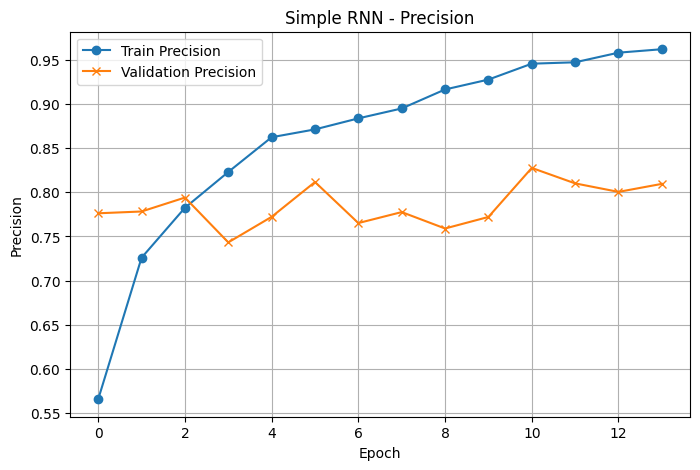

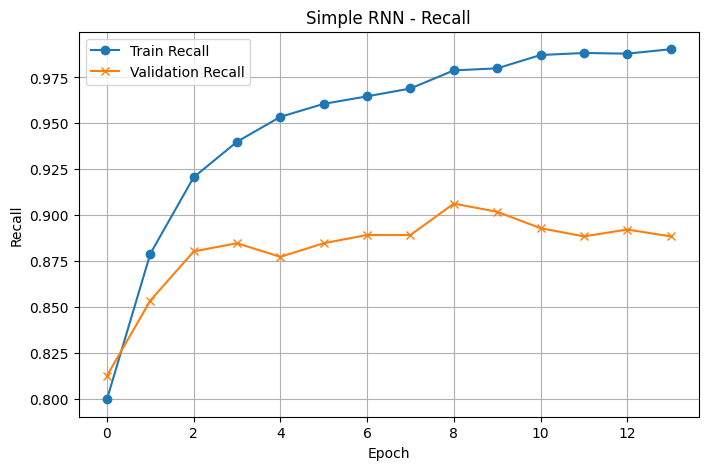

In [52]:
simple_rnn_train_precision = history_simple_rnn_with_emb.history['precision']
simple_rnn_val_precision = history_simple_rnn_with_emb.history['val_precision']

simple_rnn_train_recall = history_simple_rnn_with_emb.history['recall']
simple_rnn_val_recall = history_simple_rnn_with_emb.history['val_recall']

plt.figure(figsize=(8, 5))
plt.plot(simple_rnn_train_precision, label='Train Precision', marker='o')
plt.plot(simple_rnn_val_precision, label='Validation Precision', marker='x')
plt.title('Simple RNN - Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(simple_rnn_train_recall, label='Train Recall', marker='o')
plt.plot(simple_rnn_val_recall, label='Validation Recall', marker='x')
plt.title('Simple RNN - Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()
plt.grid(True)
plt.show()


> In the precision and recall plots of the simple rnn model, we can notice that value of training precision and recall are in a constant smooth rise, but the validation precision and recall are getting inverse dip and spike, that means when precision's value is higher, the recall's value is lower and vice versa.

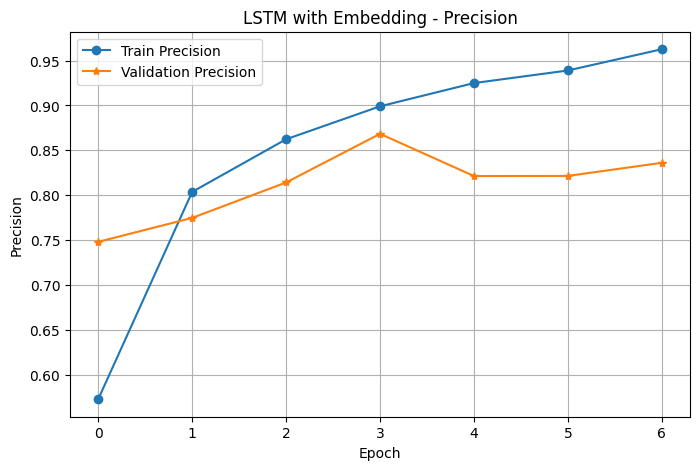

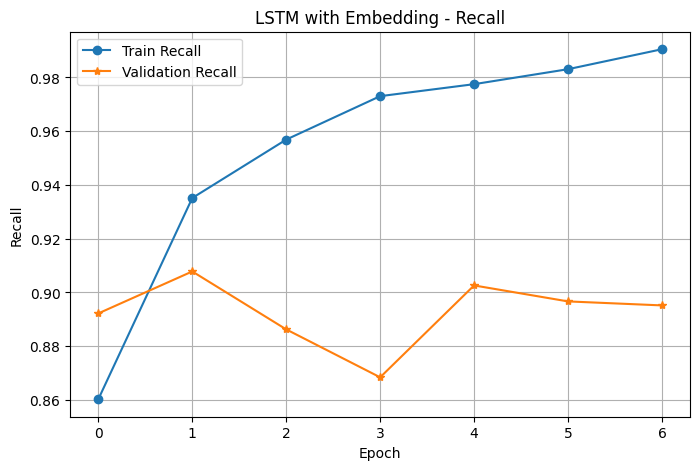

In [53]:
lstm_model_with_emb_train_precision = history_lstm_with_emb.history['precision']
lstm_model_with_emb_val_precision = history_lstm_with_emb.history['val_precision']

lstm_model_with_emb_train_recall = history_lstm_with_emb.history['recall']
lstm_model_with_emb_val_recall = history_lstm_with_emb.history['val_recall']

plt.figure(figsize=(8, 5))
plt.plot(lstm_model_with_emb_train_precision, label='Train Precision', marker='o')
plt.plot(lstm_model_with_emb_val_precision, label='Validation Precision', marker='*')
plt.title('LSTM with Embedding - Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(lstm_model_with_emb_train_recall, label='Train Recall', marker='o')
plt.plot(lstm_model_with_emb_val_recall, label='Validation Recall', marker='*')
plt.title('LSTM with Embedding - Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()
plt.grid(True)
plt.show()

> In LSTM with trainable embedding's precision and recall plots we can notice a similar pattern, we can notice that value of training precision and recall are in a constant smooth rise, but the validation precision and recall are getting inverse dip and spike, that means when precision's value is higher, the recall's value is lower and vice versa. In the final epochs, the precisions trend looks to be in the rise whereas the recall's trend looks to be in the fall.

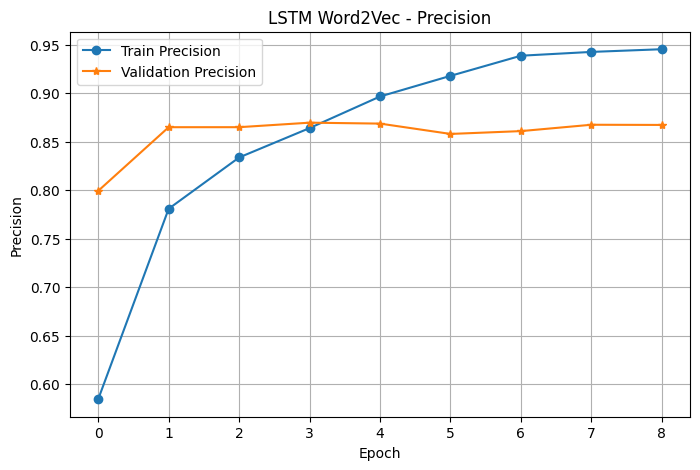

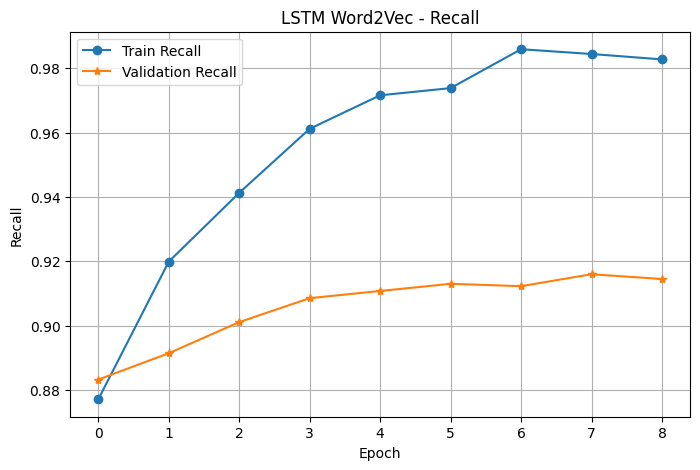

In [54]:
lstm_word2vec_model_train_precision = history_word2vec.history['precision']
lstm_word2vec_model_val_precision = history_word2vec.history['val_precision']

lstm_word2vec_model_train_recall = history_word2vec.history['recall']
lstm_word2vec_model_val_recall = history_word2vec.history['val_recall']

plt.figure(figsize=(8, 5))
plt.plot(lstm_word2vec_model_train_precision, label='Train Precision', marker='o')
plt.plot(lstm_word2vec_model_val_precision, label='Validation Precision', marker='*')
plt.title('LSTM Word2Vec - Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(lstm_word2vec_model_train_recall, label='Train Recall', marker='o')
plt.plot(lstm_word2vec_model_val_recall, label='Validation Recall', marker='*')
plt.title('LSTM Word2Vec - Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()
plt.grid(True)
plt.show()

> In the LSTM model with pretrained Word2Vec embedding layer we can see that the training precision and recall have a rising trend. But the validation precision and recall have a slighly inverse relationship, i.e. when precision is dropping, recall is rising and vice versa.

####Models and Accuracies

In [55]:
validation_predictions_simple_rnn_model = simple_rnn_model_with_emb.predict(feature_X_val_pad)
validation_predictions_simple_rnn_model = (validation_predictions_simple_rnn_model > 0.5).astype(int)

validation_predictions_lstm_model = lstm_model_with_emb.predict(feature_X_val_pad)
validation_predictions_lstm_model = (validation_predictions_lstm_model > 0.5).astype(int)

validation_predictions_lstm_word2vec_model = lstm_word2vec_model.predict(feature_X_val_pad)
validation_predictions_lstm_word2vec_model = (validation_predictions_lstm_word2vec_model > 0.5).astype(int)

228/228 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
228/228 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
228/228 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step


> Here we can storing the validation predictions of the model in their respective variables

In [56]:
accuracy_simple_rnn_model = accuracy_score(target_y_val, validation_predictions_simple_rnn_model)
accuracy_lstm_model = accuracy_score(target_y_val, validation_predictions_lstm_model)
accuracy_lstm_word2vec_model = accuracy_score(target_y_val, validation_predictions_lstm_word2vec_model)


print(f'Accuracy: ')
print(f"Simple RNN Model: {accuracy_simple_rnn_model:.4f}")
print(f"LSTM Model: {accuracy_lstm_model:.4f}")
print(f"LSTM Word2Vec Model: {accuracy_lstm_word2vec_model:.4f}")

Accuracy: 
Simple RNN Model: 0.9409
LSTM Model: 0.9343
LSTM Word2Vec Model: 0.9580


>Here we can see that all the model's accuracy is in the higher scale

> But still the model with the highest validation accuracy is LSTM Word2Vec embedding layer model with around 95% accuracy.

> Though the accuracy scores can be high, we need to make sure that precision and recall scores and good as well for a model where the dataset has highly imbalanced dataset.

####Classification Report

In [57]:
cr_simple_rnn = classification_report(target_y_val, validation_predictions_simple_rnn_model)
print('Classification Report Simple RNN:')
print(cr_simple_rnn)

cr_lstm = classification_report(target_y_val, validation_predictions_lstm_model)
print('Classification Report LSTM:')
print(cr_lstm)

cr_lstm_word2vec = classification_report(target_y_val, validation_predictions_lstm_word2vec_model)
print('Classification Report LSTM Word2Vec:')
print(cr_lstm_word2vec)

Classification Report Simple RNN:
              precision    recall  f1-score   support

           0       0.97      0.95      0.96      5945
           1       0.81      0.88      0.85      1345

    accuracy                           0.94      7290
   macro avg       0.89      0.92      0.91      7290
weighted avg       0.94      0.94      0.94      7290

Classification Report LSTM:
              precision    recall  f1-score   support

           0       0.98      0.94      0.96      5945
           1       0.77      0.91      0.84      1345

    accuracy                           0.93      7290
   macro avg       0.88      0.92      0.90      7290
weighted avg       0.94      0.93      0.94      7290

Classification Report LSTM Word2Vec:
              precision    recall  f1-score   support

           0       0.98      0.97      0.97      5945
           1       0.87      0.91      0.89      1345

    accuracy                           0.96      7290
   macro avg       0.92      

> These are the classification reports of the 3 models:

>Simple RNN Model:
- Precision: 0.88
- Recall: 0.91
- F1-Score: 90

>LSTM Model with trainable embedding Layer:
- Precision: 0.90
- Recall: 0.92
- F1-Score: 91

>LSTM Model with Word2Vec Embedding Layer:
- Precision: 0.90
- Recall: 0.94
- F1-Score: 92

>From the above observations we can see that all three models are performing quite well in predicting the correct classes. The model with the best accuracy, precision and recall is LSTM Word2Vec model which has only a very small advantage over the other models.

####Confusion Matrix

In [58]:
cm_simple_rnn = confusion_matrix(target_y_val, validation_predictions_simple_rnn_model)
cm_lstm = confusion_matrix(target_y_val, validation_predictions_lstm_model)
cm_lstm_word2vec = confusion_matrix(target_y_val, validation_predictions_lstm_word2vec_model)

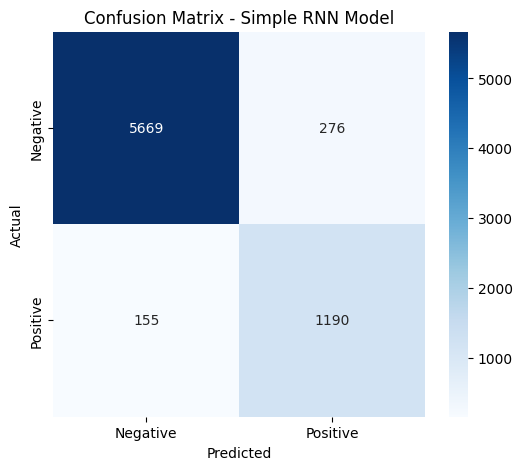

In [59]:
plt.figure(figsize=(6, 5))
sns.heatmap(cm_simple_rnn, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix - Simple RNN Model')
plt.show()

> Here we can see the Confusion matrix of the Simple RNN Model:
- True Negatives: 5647
- False Negatives: 298
- True Positives: 1179
- False Positives: 166

> From the confusion matrix we can see that how the model has performed actually in the unseen dataset. The performance is the model is quite good as it is predicting the outputs quite accurately. But we can see that there can be improvements as the model is still falsely predicting around 464 texts in 7290 total texts.


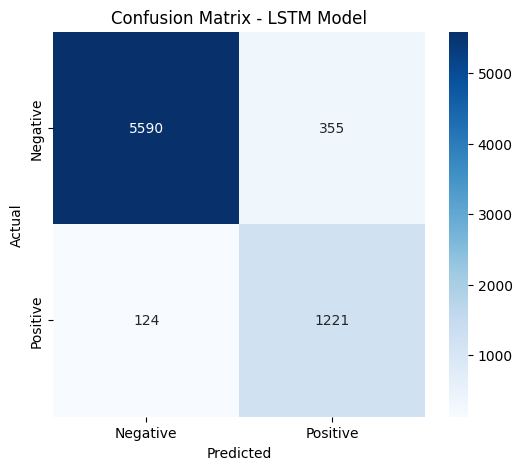

In [60]:
plt.figure(figsize=(6, 5))
sns.heatmap(cm_lstm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix - LSTM Model')
plt.show()

> Here we can see the Confusion matrix of the Simple RNN Model:
- True Negatives: 5696
- False Negatives: 249
- True Positives: 1185
- False Positives: 160

> From the confusion matrix we can see that how the model has performed actually in the unseen dataset. The performance is the model is quite good as it is predicting the outputs quite accurately. But we can see that there can be improvements as the model is still falsely predicting around 409 texts in 7290 total texts.


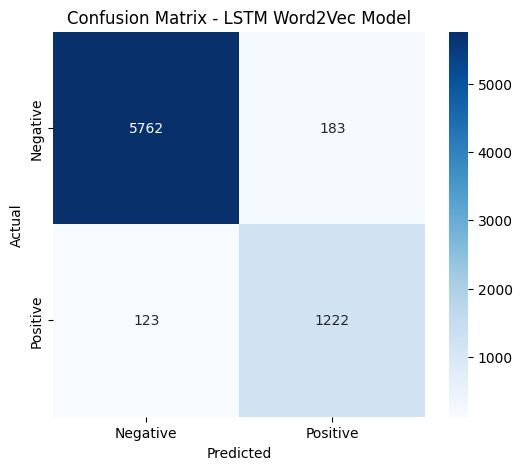

In [61]:
plt.figure(figsize=(6, 5))
sns.heatmap(cm_lstm_word2vec, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix - LSTM Word2Vec Model')
plt.show()

> Here we can see the Confusion matrix of the Simple RNN Model:
- True Negatives: 5663
- False Negatives: 282
- True Positives: 1257
- False Positives: 88

> From the confusion matrix we can see that how the model has performed actually in the unseen dataset. The performance is the model is quite good as it is predicting the outputs quite accurately. But we can see that there can be improvements as the model is still falsely predicting around 370 texts in 7290 total texts.


####Predictions on Test Dataset

In [62]:
test_predictions_simple_rnn_model = (simple_rnn_model_with_emb.predict(feature_X_test_pad) > 0.5).astype("int32")
test_predictions_lstm_model = (lstm_model_with_emb.predict(feature_X_test_pad) > 0.5).astype("int32")
test_predictions_lstm_word2vec_model = (lstm_word2vec_model.predict(feature_X_test_pad) > 0.5).astype("int32")

test_df['predicted_label_simple_rnn'] = test_predictions_simple_rnn_model
test_df['predicted_label_lstm'] = test_predictions_lstm_model
test_df['predicted_label_lstm_word2vec'] = test_predictions_lstm_word2vec_model

538/538 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
538/538 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
538/538 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step


> Here now we're predicting the sentiment of the tweets of the testing dataset and storing the labels in the test dataset itself creating a new column of the lables predicted by each model

In [63]:
test_df.head()

,tweet,cleaned_tweet,predicted_label_simple_rnn,predicted_label_lstm,predicted_label_lstm_word2vec
0,#studiolife #aislife #requires #passion #dedic...,studiolife aislife requires passion dedication...,1,1,1
1,@user #white #supremacists want everyone to s...,white supremacist want everyone see new bird m...,1,1,1
2,safe ways to heal your #acne!! #altwaystohe...,safe way heal acne altwaystoheal healthy healing,1,1,0
3,is the hp and the cursed child book up for res...,hp cursed child book reservation already yes h...,1,1,0
4,"3rd #bihday to my amazing, hilarious #nephew...",rd bihday amazing hilarious nephew eli ahmir u...,0,0,0


> These are the top 5 rows of the test data after the prediction is performed and the model wise labels are added

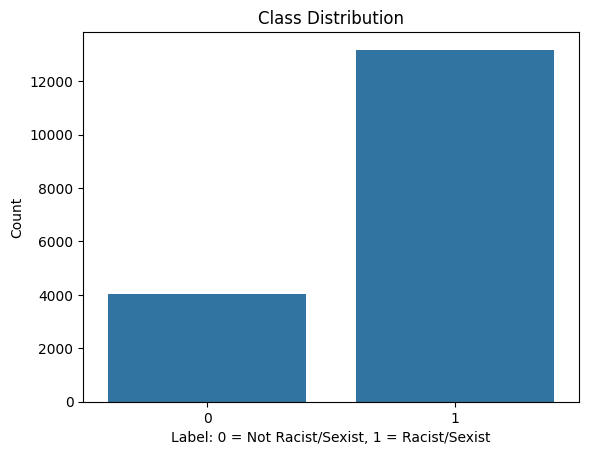

In [64]:
sns.countplot(x='predicted_label_simple_rnn', data=test_df)
plt.title("Class Distribution")
plt.xlabel("Label: 0 = Not Racist/Sexist, 1 = Racist/Sexist")
plt.ylabel("Count")
plt.show()

> Here we can see the class distribution of test dataset whil using the Simple RNN model, the "1 or Racist/Sexist" class has been predicted extremely high number of times than "0 or Nor Racist/Sexist" class.

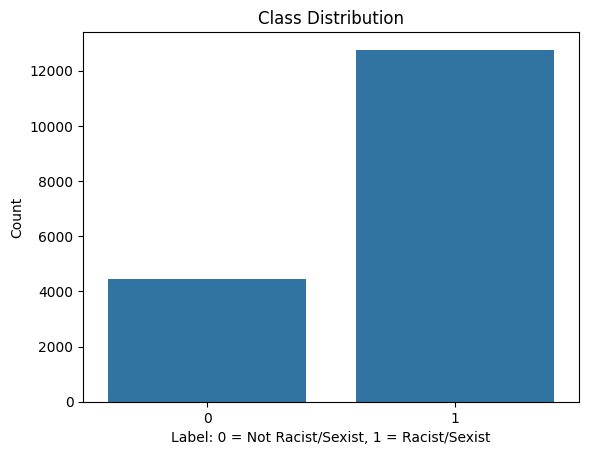

In [65]:
sns.countplot(x='predicted_label_lstm', data=test_df)
plt.title("Class Distribution")
plt.xlabel("Label: 0 = Not Racist/Sexist, 1 = Racist/Sexist")
plt.ylabel("Count")
plt.show()

> Similarly we can see the similar trends in the LSTM model with trainable embeddings also predicting large amount of data as "1 or Racist/Sexist" as compared to "0 or Not Racist/Sexist"

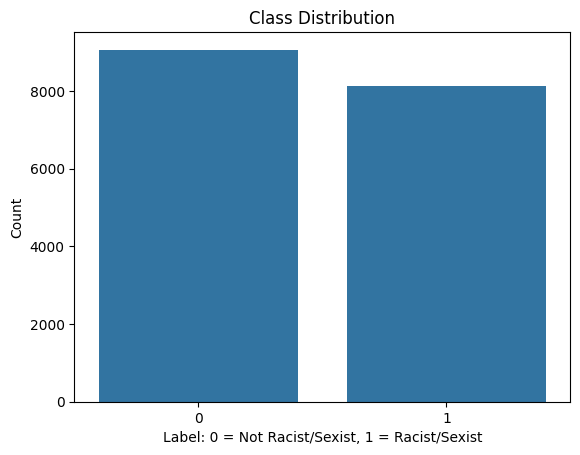

In [66]:
sns.countplot(x='predicted_label_lstm_word2vec', data=test_df)
plt.title("Class Distribution")
plt.xlabel("Label: 0 = Not Racist/Sexist, 1 = Racist/Sexist")
plt.ylabel("Count")
plt.show()

> But here in the predictions of the LSTM model with Word2Vec embeddings we can see a different story where there are slighly more "0 or Not Racist/Sexist" predictions than "1 or Racist/Sexist" predictions.

>This looks to be more accuracte and realistic predictions as the data is more well distributed but as the testing data do not have any correct labels we can't be sure which one is the better performing model in the test data.

##GUI for Real-Time Prediction

In [68]:
simple_rnn_model = load_model("/content/drive/MyDrive/AI/simple_rnn_pred_model.keras")
lstm_model = load_model("/content/drive/MyDrive/AI/lstm_pred_model.keras")
lstm_word2vec_model = load_model("/content/drive/MyDrive/AI/lstm_word2vec_pred_model.keras")
#here we're loading the trained models which we saved at the time of training using the ModelCheckPoint Class

with open("/content/drive/MyDrive/AI/tokenizer.pkl", "rb") as f:
    tokenizer = pickle.load(f)
#here the token is being loaded which was used at the time of training, this is to ensure the input text is processed in the same way as in training and in prediction

MAXLEN = lstm_word2vec_model.input_shape[1] #here it gets the input length required by the lstm_word2vec_model to make sure that the input sequences are padded correctly

def predict_racistSexist_or_not(Text): #this function is used to take a text and to make predictions based on the received text
  if not Text.strip(): #if the user sends an empty text this if statement handles it
        return "Empty text box .... Please Enter a sentence"



  word_count = len(Text.split()) #this is used for setting the minimum number of word count required for the model to predict
  if word_count < 3: #there should be at least three words
      return f"Enter at least 3 words (Right now there are only {word_count} words)"

  cleaned = get_em_cleaned(Text) #this is used to clean the user's input if there are any unneccsary character
  seq = tokenizer.texts_to_sequences([cleaned]) #it takes a input text and converts it into sequnce of integers using the same token as used in the training
  padded = pad_sequences(seq, maxlen=MAXLEN, padding='post', truncating='post') #it makes the sequences are the same length as in training and adds extra 0s after the sequence it also truncates the extra word after the word limit

  prob_rnn = simple_rnn_model.predict(padded)[0][0] #the model predictions are happening here where the model returns value in the range 0 to 1
  prob_lstm = lstm_model.predict(padded)[0][0]
  prob_lstm_w2v = lstm_word2vec_model.predict(padded)[0][0]

  #now here we've set a threshold i.e. 0.5 to determine if the given text is racist or not
  label_rnn = "You're a Racist or Sexist" if prob_rnn > 0.5 else "Congrats! You're Racist or Sexist"
  label_lstm = "You're a Racist or Sexist" if prob_lstm > 0.5 else "Congrats! You're Not Racist or Sexist"
  label_lstm_w2v = "You're a Racist or Sexist" if prob_lstm_w2v > 0.5 else "Congrats! You're Racist or Sexist"

  return (
      f"Simple RNN Model:\n{label_rnn} \n You are {prob_rnn* 100 :.2f}% Racist or Sexist 😅\n\n"
      f"LSTM Model:\n{label_lstm} \n You are {prob_lstm * 100 :.2f}% Racist or Sexist 😅\n\n"
      f"LSTM Word2Vec Model:\n{label_lstm_w2v} \n You are {prob_lstm_w2v * 100:.2f}% Racist or Sexist 😅"
  )

#this is the gradio GUI which creates a simple text box for input and a text based output that displays the models' prediction
iface = gr.Interface(
    fn=predict_racistSexist_or_not, #this is the main function that handles the interface
    inputs=gr.Textbox(lines=3, placeholder="Your Text Here.."), #this is input which the user enter and is passed to the function as arugument
    outputs="text", #type of output to be displayed
    title="Are you a Racist or Sexist ?", #title of the interface
    description="Check if you're racist or sexist by entering your sentence in the text box" #description of the interface
)

iface.launch() #it is used to start the Gradio interface and displaying it here


It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://5e48003f17efef118a.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
